# Q3 A PAT application

In 2004, the Food and Drug Administration (FDA) released a guidance to encourage innovation in pharmaceutical development, manufacturing and quality assurance. The framework, called Process Analytical Technology (PAT), combines MultiVariate Data Analysis (MVDA), Design of Experiments (DoE) and process analytical chemistry methods such as UV, IR, NIR, NMR (fast, precise, online and preferably non-invasive methods).

Here, we use PCA and PLS, two classic MVDA approaches to assess the feasibility of using NIR to measure a critical quality component of a wood product, the composition of wood fiber. In the first part, we will perform unsupervised data exploration with PCA. In the second part, we will run PLS, a supervised learning algorithm, to quantify the outputs of interest (i.e. wood composition).

## 3.1 Description of the process

Sawdust from industrial sawing of birch, pine and spruce is mixed at different ratios to manufacture a final wood product. The NIR spectra for 15 samples of known composition of the three different types of wood were used to train the model. Each sample was tested twice (resulting in 30 rows) and NIR spectra data was collected in the range between 1100-2300 nm. Thus, the input X-table is (30 rows)x(1201 columns) and the output Y-table is (30 rows)x(3 columns), where the three outputs/compositions are recorded as percent proportion of spruce, pine and birch. Data for the training of the model are in the file sawdust train.xlsx.

In order to assess the accuracy of the model developed, we have a test data set of NIR data (X) and proportions Y different than the training data set. The test data set is not ”seen” by the model during training. The proportions in the test set were selected to be different than those in the train set to assess the predictive power of the model under realistic conditions. There were 12 samples measured twice, therefore the number of rows in the X and Y-tables is 24. The test data are in the file sawdust pred.xlsx

## 3.2 Task #1: Unsupervised learning, PCA of NIR data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from adjustText import adjust_text
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import MaxNLocator
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression

from bokeh.models import ColumnDataSource, LabelSet, Arrow, NormalHead, OpenHead, VeeHead, ColorBar
from bokeh.plotting import figure, output_file, show
from bokeh.transform import linear_cmap
from bokeh.palettes import RdBu

In [2]:
Training_data = pd.read_excel('sawdust_train.xlsx')
Training_data.head()

,Primary ID,OBSNAM,w1100,w1101,w1102,w1103,w1104,w1105,w1106,w1107,...,w2294,w2295,w2296,w2297,w2298,w2299,w2300,Spruce,Pine,Birch
0,1,02a,1.83444,1.83416,1.83350,1.83237,1.83084,1.82910,1.82742,1.82611,...,0.568213,0.572867,0.577625,0.582679,0.587850,0.593058,0.598025,0.00,100.00,0.00
1,2,02b,1.82992,1.82965,1.82902,1.82800,1.82667,1.82501,1.82347,1.82225,...,0.566549,0.571178,0.575774,0.580471,0.585226,0.589929,0.594470,0.00,100.00,0.00
2,5,15a,1.84602,1.84569,1.84522,1.84431,1.84311,1.84172,1.84035,1.83918,...,0.561938,0.566829,0.571796,0.577128,0.582482,0.587653,0.592419,33.33,33.33,33.33
3,6,15b,1.84556,1.84514,1.84444,1.84340,1.84206,1.84054,1.83912,1.83795,...,0.563561,0.568268,0.572794,0.577536,0.582409,0.587451,0.592277,33.33,33.33,33.33
4,9,08a,1.83770,1.83723,1.83646,1.83532,1.83385,1.83222,1.83070,1.82958,...,0.563027,0.567910,0.572684,0.577522,0.582369,0.587133,0.591635,0.00,66.65,33.35


In [3]:
Training_data.shape

(30, 1206)

In [4]:
Test_data = pd.read_excel('sawdust_pred.xlsx')
Test_data.head()

,Primary ID,OBSNAM,w1100,w1101,w1102,w1103,w1104,w1105,w1106,w1107,...,w2294,w2295,w2296,w2297,w2298,w2299,w2300,Spruce,Pine,Birch
0,3,27a,1.81358,1.81322,1.81260,1.81163,1.81039,1.80906,1.80790,1.80710,...,0.554158,0.559145,0.564020,0.569030,0.574032,0.578976,0.583663,10,10,80
1,4,27b,1.81596,1.81561,1.81501,1.81407,1.81282,1.81141,1.81011,1.80915,...,0.553986,0.558641,0.563356,0.568291,0.573301,0.578249,0.582786,10,10,80
2,7,25a,1.78716,1.78692,1.78634,1.78540,1.78391,1.78218,1.78059,1.77917,...,0.550425,0.554899,0.559244,0.563942,0.568828,0.573971,0.579059,80,10,10
3,8,25b,1.78042,1.77997,1.77926,1.77823,1.77693,1.77544,1.77406,1.77293,...,0.546347,0.551737,0.556951,0.562219,0.567279,0.572146,0.576698,80,10,10
4,13,17a,1.77133,1.77099,1.77031,1.76935,1.76811,1.76680,1.76563,1.76467,...,0.531376,0.535909,0.540315,0.544800,0.549163,0.553316,0.557163,25,50,25


In [5]:
Test_data.shape

(24, 1206)

### A. Generate the plot of all the training set raw NIR data.

In [6]:
NIR_spectra = Training_data.iloc[:,2:1203]
NIR_spectra.head()

,w1100,w1101,w1102,w1103,w1104,w1105,w1106,w1107,w1108,w1109,...,w2291,w2292,w2293,w2294,w2295,w2296,w2297,w2298,w2299,w2300
0,1.83444,1.83416,1.83350,1.83237,1.83084,1.82910,1.82742,1.82611,1.82516,1.82452,...,0.554586,0.559044,0.563587,0.568213,0.572867,0.577625,0.582679,0.587850,0.593058,0.598025
1,1.82992,1.82965,1.82902,1.82800,1.82667,1.82501,1.82347,1.82225,1.82135,1.82070,...,0.551910,0.556829,0.561744,0.566549,0.571178,0.575774,0.580471,0.585226,0.589929,0.594470
2,1.84602,1.84569,1.84522,1.84431,1.84311,1.84172,1.84035,1.83918,1.83834,1.83773,...,0.547198,0.552090,0.557003,0.561938,0.566829,0.571796,0.577128,0.582482,0.587653,0.592419
3,1.84556,1.84514,1.84444,1.84340,1.84206,1.84054,1.83912,1.83795,1.83714,1.83658,...,0.547984,0.553266,0.558515,0.563561,0.568268,0.572794,0.577536,0.582409,0.587451,0.592277
4,1.83770,1.83723,1.83646,1.83532,1.83385,1.83222,1.83070,1.82958,1.82862,1.82806,...,0.547705,0.552726,0.557880,0.563027,0.567910,0.572684,0.577522,0.582369,0.587133,0.591635


<AxesSubplot:title={'center':'Raw NIR data of 1201 data points (lines)'}, xlabel='Wavelength', ylabel='Signal'>

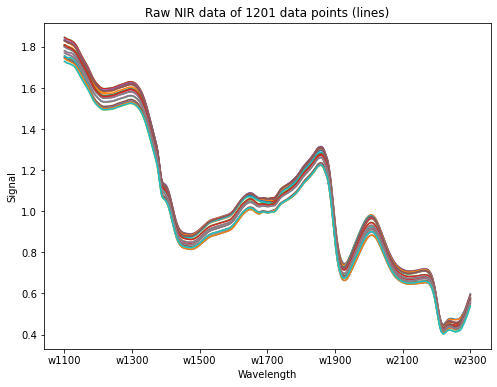

In [7]:
NIR_spectra.transpose().plot(legend=None,
                              figsize=(8,6),
                              title='Raw NIR data of 1201 data points (lines)',
                              xlabel='Wavelength',
                              ylabel='Signal')

### B. Pre-process the NIR data and perform PCA for 5 components.

#### Standardize the Data

In [8]:
scaler = StandardScaler()
scaler
NIR_spectra_scaled = scaler.fit_transform(NIR_spectra)
NIR_spectra_scaled

# NIR_spectra_scaled = StandardScaler().fit_transform(NIR_spectra)

# NIR_spectra_scaled

array([[ 1.15479144,  1.15860689,  1.15985448, ...,  1.67107466,
         1.69000461,  1.71077428],
       [ 1.02614184,  1.03027748,  1.03232182, ...,  1.50774401,
         1.49598972,  1.4927867 ],
       [ 1.48438488,  1.4866863 ,  1.49348902, ...,  1.33694397,
         1.35486544,  1.36702228],
       ...,
       [-0.67248827, -0.67869472, -0.67855155, ..., -0.82376371,
        -0.79814793, -0.78716101],
       [-1.85936621, -1.86552839, -1.86563007, ..., -1.92574765,
        -1.93817914, -1.95448296],
       [-1.80955718, -1.81345681, -1.81552796, ..., -1.92506296,
        -1.91430706, -1.91591357]])

In [9]:
# To confirm that the mean of each of the 1201 variables X is 0
NIR_spectra_scaled.mean(axis=0) 

array([ 2.10942375e-15,  8.51170986e-16, -1.45069142e-15, ...,
       -9.32587341e-16,  5.71394783e-15,  2.05021185e-15])

In [10]:
# To confirm that the std of each of the 1201 variables X is 0
NIR_spectra_scaled.std(axis=0) 

array([1., 1., 1., ..., 1., 1., 1.])

#### Performing PCA with 5 PCs

In [11]:
pca = PCA(n_components = 5, svd_solver = 'full')

NIR_scores = pca.fit_transform(NIR_spectra_scaled)
# NIR_scores.shape

#### Extracting the scores

In [12]:
# Scores are meant to reproduce the index/rows's data in the form of PCA.

NIR_scores_pd = pd.DataFrame(data = NIR_scores,
                                        columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'],
                                        index = NIR_spectra.index)
NIR_scores_pd

,PC1,PC2,PC3,PC4,PC5
0,-42.268493,-4.040753,12.305789,-0.216578,0.168393
1,-36.354122,-4.346712,11.761122,-1.134579,-0.087849
2,-37.057664,-10.544641,-2.211747,0.989693,-0.906091
3,-37.052219,-10.376199,-1.876075,1.068672,-1.039932
4,-44.838660,-1.286436,3.611384,-1.353460,-0.279127
5,-41.555269,-0.534161,3.624322,-1.446707,-0.282848
6,-18.429982,12.203720,1.642649,4.719164,-0.115531
7,-20.471809,11.998962,2.013402,4.495532,-0.173509
8,3.330350,-9.772481,-1.652964,2.157331,0.000344
9,8.134331,-8.917490,-1.595358,2.224984,-0.013582


#### Extracting the loadings

In [13]:
NIR_loadings_pd = pd.DataFrame(data = pca.components_.T
                           ,columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
                           ,index = NIR_spectra.columns)
NIR_loadings_pd

,PC1,PC2,PC3,PC4,PC5
w1100,-0.025512,-0.056479,-0.013096,-0.036032,0.018883
w1101,-0.025549,-0.056289,-0.012954,-0.035982,0.015580
w1102,-0.025582,-0.056108,-0.012888,-0.036273,0.012370
w1103,-0.025602,-0.055994,-0.012859,-0.036626,0.010389
w1104,-0.025608,-0.055937,-0.012931,-0.037125,0.009627
...,...,...,...,...,...
w2296,-0.028606,-0.019799,0.037978,0.084075,-0.071664
w2297,-0.028608,-0.019760,0.037446,0.086592,-0.067330
w2298,-0.028594,-0.019730,0.037271,0.089208,-0.064559
w2299,-0.028561,-0.019801,0.037263,0.091904,-0.067460


### C. Plot the cumulative explained variance versus the number of components. How many components do we need to capture 99% of the variance?

#### Some PCA diagnostics that show and explain the Varience

In [14]:
pca.explained_variance_

array([1.11848943e+03, 9.22380195e+01, 2.50632674e+01, 5.62850897e+00,
       3.49539760e-01])

In [15]:
pca.explained_variance_ratio_*100

array([9.00255162e+01, 7.42409816e+00, 2.01730434e+00, 4.53030142e-01,
       2.81339247e-02])

#### Plotting the varience graph

In [16]:
pca = PCA(n_components = 5, svd_solver = 'full')

In [17]:
pca.fit(NIR_spectra_scaled)

PCA(n_components=5, svd_solver='full')

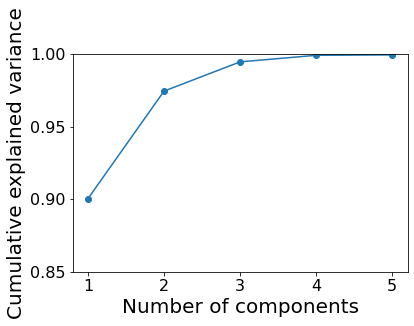

In [18]:
plt.plot(range(1,pca.n_components+1), np.cumsum(pca.explained_variance_ratio_),'-o')
plt.xlabel('Number of components', fontsize=20)
plt.ylabel('Cumulative explained variance', fontsize=20);
plt.tick_params(labelsize=16)
plt.ylim(0.85,1)
plt.show()

#### How many components do we need to capture 99% of the variance?

3 PCs caputure 99% of the varience in the data.

### D. Plot the PCA scores for the first two components. Comment on any outliers, trends, clusters etc (if any).

In [19]:
def score_plot(scores, score_labels=None):
    # adjusting the scores to fit in (-1,1)
    xt = scores[:,0]
    yt = scores[:,1]
    scalext = 1.0/(xt.max() - xt.min())
    scaleyt = 1.0/(yt.max() - yt.min())
    xt_scaled = xt * scalext
    yt_scaled = yt * scaleyt
    
    fig = plt.figure(figsize=(9, 9))
    for (x,y), label in zip(np.vstack((xt_scaled, yt_scaled)).T, score_labels):
        plt.text(x, y, label, ha='center', size=11)
        
    plt.hlines(0, -1, 1, linestyles='solid', linewidth=3)
    plt.vlines(0, -1, 1, linestyles='solid', linewidth=3)
    
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1), fontsize=20);
    plt.ylabel("PC{}".format(2), fontsize=20);
    plt.tick_params(labelsize=16)
    plt.grid()

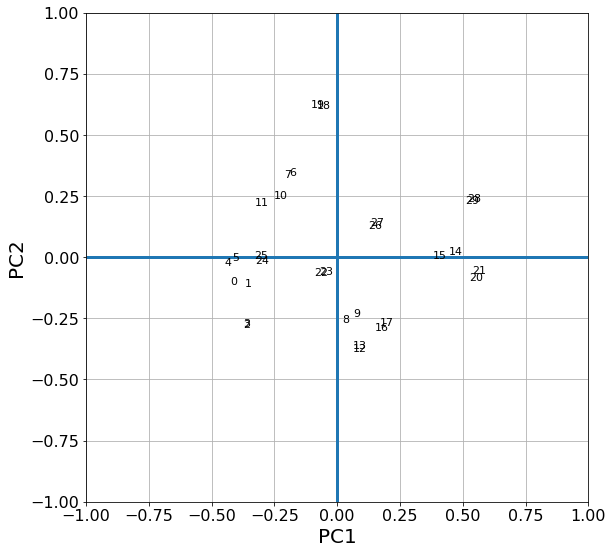

In [20]:
score_plot(NIR_scores[:,:2], score_labels=NIR_scores_pd.index)
plt.show()

#### Comment on any outliers, trends, clusters etc (if any).

There aren't any trends or outliers as such, however there are a few minor clusters of data if we are to define clusters by very small amounts of data grouped together.

There's a few tightly around the centre, and a few around the negative y-axis and negative x-axis. Another major cluster is by 0.5 of PC1 that shows a variety of numbers.

Although, there is one thing to keep in mind that these plotting may not exactly say that they are clusted around each other, there can be far away from each other in reality because of the other dimension that is not plotted and because it's not feasible to plot more than 3 dimensions.

### E. Plot the loadings of the first two components and comment on which wavelengths seem to be important for different PCs. Don’t describe the graphs in words. In two sentences, describe any significant trends or signals (if any).

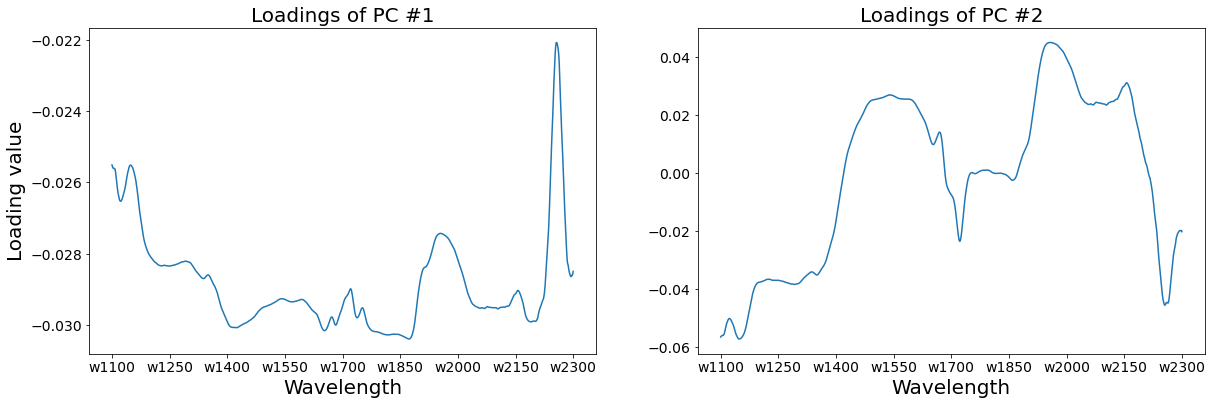

In [21]:
fig0 = plt.figure(figsize=(20, 6))
sub1 = fig0.add_subplot(121)
plt.plot(NIR_loadings_pd['PC1'],'-')
sub1.set_xlabel('Wavelength', fontsize=20)
sub1.set_ylabel('Loading value', fontsize=20)
sub1.set_title('Loadings of PC #1', fontsize=20)
sub1.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tick_params(labelsize=14)

sub2 = fig0.add_subplot(122)
plt.plot(NIR_loadings_pd['PC2'],'-')
sub2.set_xlabel('Wavelength', fontsize=20)
sub2.set_title('Loadings of PC #2', fontsize=20)
sub2.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tick_params(labelsize=14)

plt.show()

#### In two sentences, describe any significant trends or signals (if any).

The first PC captures predominantly information from the wavelengths that corresponds to w1100-w1400,w1850-w2000 and w2190-w2300.
PC2 captures information from the wavelengths between w1400-w2270 with a short drop from w1650-w1850.

### F. Apply the dimensionality reduction with the PCA model you developed in step B for the test set using the transform method.

In [22]:
NIR_test_spectra = Test_data.iloc[:,2:1203]
NIR_test_spectra

,w1100,w1101,w1102,w1103,w1104,w1105,w1106,w1107,w1108,w1109,...,w2291,w2292,w2293,w2294,w2295,w2296,w2297,w2298,w2299,w2300
0,1.81358,1.81322,1.81260,1.81163,1.81039,1.80906,1.80790,1.80710,1.80665,1.80652,...,0.538656,0.543831,0.549036,0.554158,0.559145,0.564020,0.569030,0.574032,0.578976,0.583663
1,1.81596,1.81561,1.81501,1.81407,1.81282,1.81141,1.81011,1.80915,1.80864,1.80852,...,0.539687,0.544487,0.549293,0.553986,0.558641,0.563356,0.568291,0.573301,0.578249,0.582786
2,1.78716,1.78692,1.78634,1.78540,1.78391,1.78218,1.78059,1.77917,1.77823,1.77766,...,0.535891,0.540838,0.545726,0.550425,0.554899,0.559244,0.563942,0.568828,0.573971,0.579059
3,1.78042,1.77997,1.77926,1.77823,1.77693,1.77544,1.77406,1.77293,1.77212,1.77133,...,0.530337,0.535487,0.540901,0.546347,0.551737,0.556951,0.562219,0.567279,0.572146,0.576698
4,1.77133,1.77099,1.77031,1.76935,1.76811,1.76680,1.76563,1.76467,1.76401,1.76346,...,0.517237,0.521950,0.526659,0.531376,0.535909,0.540315,0.544800,0.549163,0.553316,0.557163
5,1.76519,1.76477,1.76401,1.76292,1.76143,1.75980,1.75824,1.75704,1.75625,1.75572,...,0.512516,0.517724,0.522906,0.528003,0.532696,0.537328,0.542243,0.547303,0.552375,0.556934
6,1.80338,1.80302,1.80225,1.80105,1.79942,1.79753,1.79581,1.79451,1.79374,1.79332,...,0.532382,0.537769,0.543276,0.548729,0.554031,0.559213,0.564588,0.569960,0.575186,0.580128
7,1.80347,1.80308,1.80243,1.80148,1.80018,1.79860,1.79707,1.79572,1.79466,1.79390,...,0.534359,0.539131,0.544370,0.549973,0.555515,0.560995,0.566629,0.572065,0.577189,0.581623
8,1.77958,1.77923,1.77851,1.77739,1.77585,1.77407,1.77236,1.77096,1.77002,1.76940,...,0.516593,0.521363,0.526337,0.531467,0.536348,0.540972,0.545828,0.550341,0.554430,0.557804
9,1.78660,1.78591,1.78499,1.78380,1.78236,1.78084,1.77951,1.77851,1.77788,1.77731,...,0.520528,0.524766,0.528765,0.532655,0.536440,0.540345,0.544834,0.549624,0.554474,0.559020


#### Standardize the Data

In [23]:
NIR_test_spectra_scaled = scaler.transform(NIR_test_spectra)
NIR_test_spectra_scaled


# NIR_spectra_test_scaled = scaler.transform(NIR_test_spectra)

# NIR_spectra_test_scaled

array([[ 0.56106785,  0.56277143,  0.56489186, ...,  0.81097445,
         0.81684462,  0.83011673],
       [ 0.62880812,  0.63077748,  0.6334976 , ...,  0.76547342,
         0.7717667 ,  0.77634032],
       [-0.19090614, -0.1855797 , -0.18265447, ...,  0.48705192,
         0.50650761,  0.54780595],
       ...,
       [-1.7429554 , -1.73975988, -1.73354268, ..., -1.83144661,
        -1.83109582, -1.83435984],
       [-0.45617478, -0.45219757, -0.45081466, ..., -0.97576578,
        -0.96302027, -0.96467832],
       [-0.30276298, -0.31106367, -0.31331851, ..., -1.01080967,
        -1.00735413, -1.00570046]])

In [24]:
# To confirm that the mean of each of the 1201 variables X is 0
NIR_test_spectra_scaled.mean(axis=0) 

array([-0.63138396, -0.63054748, -0.63033538, ..., -0.5295709 ,
       -0.52663405, -0.52501128])

In [25]:
NIR_test_spectra_scaled.std(axis=0) 

array([0.71411207, 0.71406436, 0.71417663, ..., 0.84865052, 0.85400277,
       0.86048484])

#### Performing PCA with 5 PCs

In [26]:
# pca = PCA(n_components = 5, svd_solver = 'full')

NIR_test_scores = pca.transform(NIR_test_spectra_scaled)
# NIR_scores.shape

#### Extracting the scores

In [27]:
# Scores are meant to reproduce the index/rows's data in the form of PCA.

NIR_test_scores_pd = pd.DataFrame(data = NIR_test_scores,
                                        columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'],
                                        index = NIR_test_spectra.index)
NIR_test_scores_pd

,PC1,PC2,PC3,PC4,PC5
0,-27.618552,3.081252,-4.490109,0.858742,-2.164640
1,-26.843671,1.913231,-4.717328,0.121521,-2.673488
2,18.585434,-8.877615,3.137680,6.931751,-1.139065
3,23.818217,-7.586070,3.616267,6.846051,-1.068361
4,29.859483,-1.550916,1.809584,-0.993520,-1.673984
5,33.643947,0.217732,2.101609,-0.898524,-1.447926
6,-8.385014,-2.276177,-1.604266,3.433392,-0.375130
7,-11.150608,-1.325693,-1.868910,3.784158,-0.016490
8,22.998265,-2.487411,3.045056,-1.992053,-0.083291
9,17.734735,-2.974622,2.976257,-2.284470,0.160592


#### Extracting the loadings

In [28]:
NIR_test_loadings_pd = pd.DataFrame(data = pca.components_.T
                           ,columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
                           ,index = NIR_test_spectra.columns)
NIR_test_loadings_pd

,PC1,PC2,PC3,PC4,PC5
w1100,-0.025512,-0.056479,-0.013096,-0.036032,0.018883
w1101,-0.025549,-0.056289,-0.012954,-0.035982,0.015580
w1102,-0.025582,-0.056108,-0.012888,-0.036273,0.012370
w1103,-0.025602,-0.055994,-0.012859,-0.036626,0.010389
w1104,-0.025608,-0.055937,-0.012931,-0.037125,0.009627
...,...,...,...,...,...
w2296,-0.028606,-0.019799,0.037978,0.084075,-0.071664
w2297,-0.028608,-0.019760,0.037446,0.086592,-0.067330
w2298,-0.028594,-0.019730,0.037271,0.089208,-0.064559
w2299,-0.028561,-0.019801,0.037263,0.091904,-0.067460


### G. Create a scatter plot of the scores in PC1, PC2 of all 54 points in the train and test data set, coloured by the set they belong to (suggestion: use sns.scatterplot). Why is it important to overlap the scores of both train and test set in one graph? What are you checking to see?

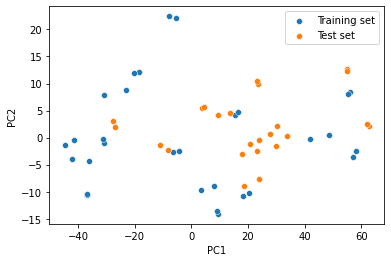

In [29]:
sns.scatterplot(data = NIR_scores_pd, x = 'PC1', y = 'PC2', label = 'Training set')
sns.scatterplot(data = NIR_test_scores_pd, x = 'PC1', y = 'PC2', label = 'Test set')
plt.legend()

It is important to overlap the scores of both, training and testing set in one graph, because it provides us an idea of the varience in the training data set aswell as the testing data set. 

We are checking to see if the output of the testing data would be strongly correlated to the training data in some way or not. In this scatter plot, the test data is somewhat correlated to the training data set.

## 3.3 Task #2: Supervised learning, PLS model

### A. Run the PLS regression to model all 3 outputs with the scaled train set spectra. Increase the number of components to achieve R^2 value of at least 0.92 (use PLS Regression’s method score to estimate R^2).

In [30]:
Y_train = Training_data.iloc[:,-3:]
Y_train.head()

,Spruce,Pine,Birch
0,0.00,100.00,0.00
1,0.00,100.00,0.00
2,33.33,33.33,33.33
3,33.33,33.33,33.33
4,0.00,66.65,33.35


In [31]:
Y_test = Test_data.iloc[:,-3:]
Y_test.head()

,Spruce,Pine,Birch
0,10,10,80
1,10,10,80
2,80,10,10
3,80,10,10
4,25,50,25


In [32]:
X_train = Training_data.iloc[:,2:-3]
X_train.head()

,w1100,w1101,w1102,w1103,w1104,w1105,w1106,w1107,w1108,w1109,...,w2291,w2292,w2293,w2294,w2295,w2296,w2297,w2298,w2299,w2300
0,1.83444,1.83416,1.83350,1.83237,1.83084,1.82910,1.82742,1.82611,1.82516,1.82452,...,0.554586,0.559044,0.563587,0.568213,0.572867,0.577625,0.582679,0.587850,0.593058,0.598025
1,1.82992,1.82965,1.82902,1.82800,1.82667,1.82501,1.82347,1.82225,1.82135,1.82070,...,0.551910,0.556829,0.561744,0.566549,0.571178,0.575774,0.580471,0.585226,0.589929,0.594470
2,1.84602,1.84569,1.84522,1.84431,1.84311,1.84172,1.84035,1.83918,1.83834,1.83773,...,0.547198,0.552090,0.557003,0.561938,0.566829,0.571796,0.577128,0.582482,0.587653,0.592419
3,1.84556,1.84514,1.84444,1.84340,1.84206,1.84054,1.83912,1.83795,1.83714,1.83658,...,0.547984,0.553266,0.558515,0.563561,0.568268,0.572794,0.577536,0.582409,0.587451,0.592277
4,1.83770,1.83723,1.83646,1.83532,1.83385,1.83222,1.83070,1.82958,1.82862,1.82806,...,0.547705,0.552726,0.557880,0.563027,0.567910,0.572684,0.577522,0.582369,0.587133,0.591635


In [33]:
X_test = Test_data.iloc[:,2:-3]
X_test.head()

,w1100,w1101,w1102,w1103,w1104,w1105,w1106,w1107,w1108,w1109,...,w2291,w2292,w2293,w2294,w2295,w2296,w2297,w2298,w2299,w2300
0,1.81358,1.81322,1.81260,1.81163,1.81039,1.80906,1.80790,1.80710,1.80665,1.80652,...,0.538656,0.543831,0.549036,0.554158,0.559145,0.564020,0.569030,0.574032,0.578976,0.583663
1,1.81596,1.81561,1.81501,1.81407,1.81282,1.81141,1.81011,1.80915,1.80864,1.80852,...,0.539687,0.544487,0.549293,0.553986,0.558641,0.563356,0.568291,0.573301,0.578249,0.582786
2,1.78716,1.78692,1.78634,1.78540,1.78391,1.78218,1.78059,1.77917,1.77823,1.77766,...,0.535891,0.540838,0.545726,0.550425,0.554899,0.559244,0.563942,0.568828,0.573971,0.579059
3,1.78042,1.77997,1.77926,1.77823,1.77693,1.77544,1.77406,1.77293,1.77212,1.77133,...,0.530337,0.535487,0.540901,0.546347,0.551737,0.556951,0.562219,0.567279,0.572146,0.576698
4,1.77133,1.77099,1.77031,1.76935,1.76811,1.76680,1.76563,1.76467,1.76401,1.76346,...,0.517237,0.521950,0.526659,0.531376,0.535909,0.540315,0.544800,0.549163,0.553316,0.557163


In [34]:
pls_sklearn = PLSRegression(n_components=3, scale=False)
pls_sklearn.fit(X_train, Y_train)

PLSRegression(n_components=3, scale=False)

In [35]:
pls_sklearn.score(X_train,Y_train)

0.9240392024759805

### B. Predict the output values for the inputs in the test set and compare them by plotting the 24 actual vs predicted values in a 1x3 subplot (for spruce, pine and birch, respectively). Also, include the y=x line for reference

In [36]:
y_train_predicted = pls_sklearn.predict(X_train)
y_test_predicted = pls_sklearn.predict(X_test)

Text(0.5, 1.0, 'Spruce')

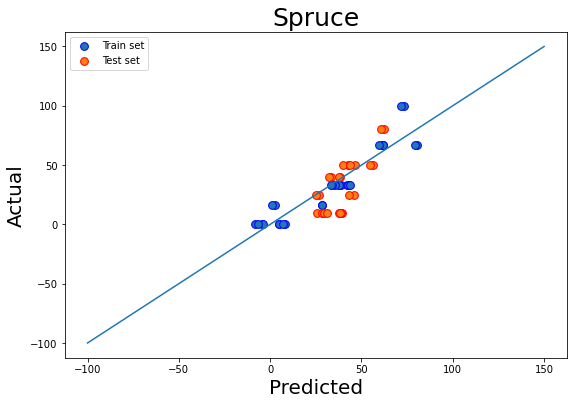

In [37]:
fig2 = plt.figure(figsize=(9, 6))
sub5 = fig2.add_subplot(111)
plt.scatter(y_train_predicted[:,:1], Y_train.iloc[:,:1], s=60, marker="o", edgecolors='b')
plt.scatter(y_test_predicted[:,:1], Y_test.iloc[:,:1], s=60, marker="o", edgecolors='r')
plt.legend(['Train set', 'Test set'])
plt.plot([-100,150], [-100,150])
plt.xlabel('Predicted', fontsize = 20)
plt.ylabel('Actual', fontsize = 20)
plt.title('Spruce', fontsize = 25)
# plt.tick_params(labelsize=16)
# plt.xlim([0, 0.02])
# plt.ylim([0, 0.02])

Text(0.5, 1.0, 'Pine')

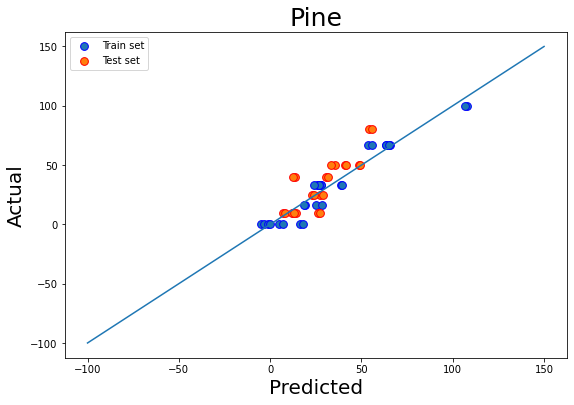

In [38]:
fig2 = plt.figure(figsize=(9, 6))
sub5 = fig2.add_subplot(111)
plt.scatter(y_train_predicted[:,1:2], Y_train.iloc[:,1:2], s=60, marker="o", edgecolors='b')
plt.scatter(y_test_predicted[:,1:2], Y_test.iloc[:,1:2], s=60, marker="o", edgecolors='r')
plt.legend(['Train set', 'Test set'])
plt.plot([-100,150], [-100,150])
plt.xlabel('Predicted', fontsize = 20)
plt.ylabel('Actual', fontsize = 20)
plt.title('Pine', fontsize = 25)
# plt.tick_params(labelsize=16)
# plt.xlim([0, 0.02])
# plt.ylim([0, 0.02])

Text(0.5, 1.0, 'Birch')

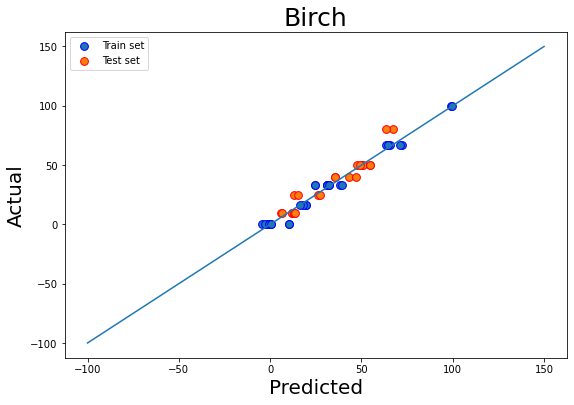

In [39]:
fig2 = plt.figure(figsize=(9, 6))
sub5 = fig2.add_subplot(111)
plt.scatter(y_train_predicted[:,2:3], Y_train.iloc[:,2:3], s=60, marker="o", edgecolors='b')
plt.scatter(y_test_predicted[:,2:3], Y_test.iloc[:,2:3], s=60, marker="o", edgecolors='r')
plt.legend(['Train set', 'Test set'])
plt.plot([-100,150], [-100,150])
plt.xlabel('Predicted', fontsize = 20)
plt.ylabel('Actual', fontsize = 20)
plt.title('Birch', fontsize = 25)
# plt.tick_params(labelsize=16)
# plt.xlim([0, 0.02])
# plt.ylim([0, 0.02])